In [1]:
# Only need to change here to load your desire model for the entire code
from tensorflow.keras.applications.nasnet import preprocess_input
from tensorflow.keras.applications import NASNetMobile
model_name = "NASNetMobile"


In [2]:
# === System & OS Utilities ===
import os
import random
import math
import pickle
import sys
import warnings
warnings.filterwarnings("ignore")

# === Progress Bar ===
from tqdm import tqdm

# === TensorFlow & Keras ===
import tensorflow as tf
from tensorflow.keras.models import Model, load_model

from tensorflow.keras.layers import (
    Layer, Conv2D, Dense, Dropout,
    GlobalAveragePooling2D, GlobalMaxPooling2D,
    Reshape, Multiply, Add, Activation, Concatenate
)
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras import Input

# === Data Handling ===
import numpy as np
import pandas as pd
import cv2

# === Visualization ===
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

# === Scikit-learn ===
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, classification_report, roc_auc_score
)

In [3]:
print("Python version:", sys.version)
print("TensorFlow version:", tf.__version__)
print("Keras version:", tf.keras.__version__)
print("NumPy version:", np.__version__)
print("Pandas version:", pd.__version__)
print("OpenCV version:", cv2.__version__)
print("Matplotlib version:", matplotlib.__version__)
print("Seaborn version:", sns.__version__)
print("Scikit-learn version:", sklearn.__version__)

Python version: 3.10.16 | packaged by Anaconda, Inc. | (main, Dec 11 2024, 16:19:12) [MSC v.1929 64 bit (AMD64)]
TensorFlow version: 2.10.1
Keras version: 2.10.0
NumPy version: 1.26.4
Pandas version: 2.2.3
OpenCV version: 4.11.0
Matplotlib version: 3.10.3
Seaborn version: 0.13.2
Scikit-learn version: 1.6.1


> You need to install specific versions of library given below to work with this notebook

The given command will install the following versions:

* Python: 3.11.11 (as per your system)

* TensorFlow: 2.18.0

* Keras: 3.5.0

* NumPy: 1.26.4

* Pandas: 2.2.3

* OpenCV: 4.6.0.66

* Matplotlib: 3.7.5

* Seaborn: 0.12.2

* Scikit-learn: 1.2.2

In [4]:
#python version 3.11.11
#!>python -m pip install tensorflow==2.18.0 keras==3.5.0 numpy==1.26.4 pandas==2.2.3 opencv-python==4.6.0.66 matplotlib==3.7.5 seaborn==0.12.2 scikit-learn==1.2.2

In [5]:
# For Windows to use graphics card (GPU) install these version
# Remember These versions are used for ALL_CNN_Models_Evaluation except Proposed Model
"""   
conda create -n py310 python=3.10
conda active py310
conda install -c conda-forge cudatoolkit=11.2 cudnn=8.1.0
python -m pip install "tensorflow<2.11" "numpy<2.0" opencv-python matplotlib scikit-learn pandas seaborn tqdm
"""

'   \nconda create -n py310 python=3.10\nconda active py310\nconda install -c conda-forge cudatoolkit=11.2 cudnn=8.1.0\npython -m pip install "tensorflow<2.11" "numpy<2.0" opencv-python matplotlib scikit-learn pandas seaborn tqdm\n'

In [6]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPUs detected: {len(gpus)}")
    except RuntimeError as e:
        print(f"Error setting GPU memory growth: {e}")
else:
    print("No GPUs detected.")

GPUs detected: 1


In [7]:
BATCH_SIZE = 16
IMG_SIZE = (224, 224)
EPOCH = 20
img_shape=(*IMG_SIZE,3)
labels = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
#labels = ['AK', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'SCC', 'UNK', 'VASC']

In [8]:
def data_frame(path):
    class_paths = []
    classes = []

    for label in os.listdir(path):
        class_dir = os.path.join(path, label)
        if os.path.isdir(class_dir):  
            for image in os.listdir(class_dir):
                class_paths.append(os.path.join(class_dir, image))
                classes.append(label)

    df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return df

In [9]:
#dataframe = data_frame('/kaggle/input/ham1000-aug-resized-organized/HAM10000_organized')
dataframe = data_frame(r"C:\Users\Antik\OneDrive - American International University-Bangladesh\Desktop\Skin Cancer Thesis Final Codes\Other Models\HAM10000_organized")
# First split: 70% train, 30% temp (val + test)
train_dataframe, temp_dataframe = train_test_split(
    dataframe,
    test_size=0.3,
    random_state=42,
    stratify=dataframe['Class']
)

# Second split: 2/3 val, 1/3 test of the 30% => 20% val, 10% test overall
validation_dataframe, test_dataframe = train_test_split(
    temp_dataframe,
    test_size=1/3,
    random_state=42,
    stratify=temp_dataframe['Class']
)

print(f"Train size: {len(train_dataframe)}, Validation size: {len(validation_dataframe)}, Test size: {len(test_dataframe)}")

Train size: 32854, Validation size: 9387, Test size: 4694


In [10]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=15,
    zoom_range=0.15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)


train_data = train_datagen.flow_from_dataframe(train_dataframe, x_col='Class Path',
                                  y_col='Class', batch_size=BATCH_SIZE,
                                  target_size=IMG_SIZE, seed=42)

validation_data = val_datagen.flow_from_dataframe(validation_dataframe, x_col='Class Path',
                                     y_col='Class', batch_size=BATCH_SIZE,
                                     target_size=IMG_SIZE, seed=42)

test_data = test_datagen.flow_from_dataframe(test_dataframe, x_col='Class Path',
                                  y_col='Class', batch_size=BATCH_SIZE,
                                  target_size=IMG_SIZE, shuffle=False, seed=42)

Found 32854 validated image filenames belonging to 7 classes.
Found 9387 validated image filenames belonging to 7 classes.
Found 4694 validated image filenames belonging to 7 classes.


In [11]:
@tf.keras.utils.register_keras_serializable(package="Custom", name="F1Score")
class F1Score(tf.keras.metrics.Metric):
    """
    Custom Keras metric to compute the F1 Score.
    The F1 score is the harmonic mean of precision and recall.
    """

    def __init__(self, name='f1_score', **kwargs):
        """
        Initializes the F1Score metric. 
        - Uses Keras' Precision and Recall metrics as intermediate steps.
        """
        super().__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()  # Precision metric
        self.recall = tf.keras.metrics.Recall()  # Recall metric

    def update_state(self, y_true, y_pred, sample_weight=None):
        """
        Updates the state of the metric.
        - This method is called during training to update precision and recall.
        - The precision and recall states are updated based on true and predicted values.
        """
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        """
        Computes and returns the F1 score.
        - F1 score is calculated as the harmonic mean of precision and recall.
        - Prevents division by zero by adding a small epsilon value to the denominator.
        """
        p = self.precision.result()  # Get precision value
        r = self.recall.result()  # Get recall value
        return 2 * (p * r) / (p + r + tf.keras.backend.epsilon())  # Calculate F1 score

    def reset_states(self):
        """
        Resets the states of the precision and recall metrics.
        - This is called at the beginning of each epoch.
        """
        self.precision.reset_states()  # Reset precision state
        self.recall.reset_states()  # Reset recall state


In [12]:
class RestoreBestValidationModel(Callback):
    """
    Custom Keras Callback to restore model weights from the best epoch based on validation accuracy.
    - Tracks the best validation accuracy during training.
    - Restores the model weights from the epoch with the best validation accuracy when training finishes.
    """
    
    def __init__(self):
        super(RestoreBestValidationModel, self).__init__()
        # Initialize best validation accuracy, epoch, and weights to track the best model
        self.best_val_acc = -1
        self.best_epoch = -1
        self.best_weights = None

    def on_epoch_end(self, epoch, logs=None):
        """
        Callback function executed at the end of each epoch.
        - Compares the current validation accuracy with the best validation accuracy.
        - If the current validation accuracy is higher or tied but at a later epoch, updates the best model weights.
        """
        # Get validation accuracy from logs
        val_acc = logs.get('val_accuracy')
        
        if val_acc is not None:
            # Update the best validation accuracy and weights if the current one is better or at a later epoch
            if val_acc > self.best_val_acc or (val_acc == self.best_val_acc and epoch > self.best_epoch):
                self.best_val_acc = val_acc
                self.best_epoch = epoch
                self.best_weights = self.model.get_weights()  # Store the model's weights
                print(f"Model weights updated at epoch {epoch + 1} with val_accuracy: {val_acc:.4f}")

    def on_train_end(self, logs=None):
        """
        Callback function executed at the end of training.
        - Restores the model weights from the epoch with the best validation accuracy.
        """
        # If we found a better model during training, restore the best weights
        if self.best_weights is not None:
            print(f"Restoring model weights from best epoch {self.best_epoch + 1} with val_accuracy: {self.best_val_acc:.4f}")
            self.model.set_weights(self.best_weights)  # Set the weights back to the best model's weights

# Instantiate the callback
restore_best = RestoreBestValidationModel()


In [13]:
# 1. Define input shape
input_tensor = Input(shape=(224, 224, 3))

# 2. Load base model dynamically without top (classification head)
# Warning-Eval is a dangerous function.
base_model = eval(f"{model_name}(weights='imagenet', include_top=False, input_tensor=input_tensor)")

# 3. Freeze base model layers (optional, if you don't want them to train initially)
base_model.trainable = False

# 4. Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(len(labels), activation='softmax')(x)  

# 5. Build final model
model = Model(inputs=base_model.input, outputs=output)

# 6. Compile the model
# Categorical cross-entropy loss is used for multi-class classification.
# Additional metrics: accuracy, precision, recall, F1 score, and AUC (Area Under the Curve).
model.compile(optimizer='adam', 
              loss='categorical_crossentropy',
               metrics=['accuracy', 
                        Precision(name='precision'), 
                        Recall(name='recall'),
                        F1Score(),
                        AUC(name='auc')])

# Print the model summary to check the architecture.
model.summary()

19993432/19993432 [==============================] - 7s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv1 (Conv2D)            (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 stem_bn1 (BatchNormalization)  (None, 111, 111, 32  128         ['stem_conv1[0][0]']             
                             

In [14]:
history = model.fit(train_data,
                 epochs=EPOCH,             
                 validation_data=validation_data,
                 callbacks=[restore_best],
                 shuffle= False)

Epoch 1/20
2054/2054 [==============================] - 279s 130ms/step - loss: 1.2250 - accuracy: 0.5352 - precision: 0.7168 - recall: 0.3396 - f1_score: 0.4608 - auc: 0.8709 - val_loss: 1.1728 - val_accuracy: 0.5536 - val_precision: 0.7071 - val_recall: 0.3960 - val_f1_score: 0.5076 - val_auc: 0.8828
Epoch 2/20
2054/2054 [==============================] - 260s 127ms/step - loss: 1.0346 - accuracy: 0.6089 - precision: 0.7488 - recall: 0.4561 - f1_score: 0.5669 - auc: 0.9094 - val_loss: 1.1089 - val_accuracy: 0.5772 - val_precision: 0.7205 - val_recall: 0.4332 - val_f1_score: 0.5411 - val_auc: 0.8956
Epoch 3/20
2054/2054 [==============================] - 260s 127ms/step - loss: 0.9675 - accuracy: 0.6333 - precision: 0.7603 - recall: 0.4948 - f1_score: 0.5995 - auc: 0.9210 - val_loss: 1.0671 - val_accuracy: 0.5889 - val_precision: 0.7319 - val_recall: 0.4567 - val_f1_score: 0.5625 - val_auc: 0.9038
Epoch 4/20
2054/2054 [==============================] - 271s 132ms/step - loss: 0.9252 -

In [15]:
model.save(f"{model_name}.keras")

In [16]:
# Save history
with open(f'{model_name} training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

In [17]:
# Load history
with open(f'{model_name} training_history.pkl', 'rb') as f:
    history = pickle.load(f)

In [18]:
epochs = range(1, len(history['loss']) + 1)

# Training and validation metrics
tr_loss = history['loss']
val_loss = history['val_loss']
tr_acc = history['accuracy']
val_acc = history['val_accuracy']
tr_precision = history['precision']
val_precision = history['val_precision']
tr_auc = history['auc']
val_auc = history['val_auc']
tr_f1 = history['f1_score']
val_f1 = history['val_f1_score']

In [19]:
def print_best_metrics(metric_name, train, val):
    best_epoch = np.argmax(val) + 1
    print(f"📌 Best {metric_name} at epoch {best_epoch}:")
    print(f"   - Train {metric_name}: {abs(train[best_epoch - 1]):.4f}")
    print(f"   - Val {metric_name}:   {abs(val[best_epoch - 1]):.4f}\n")
    return {
        "epoch": best_epoch,
        "train": float(f"{abs(train[best_epoch - 1]):.4f}"),
        "val": float(f"{abs(val[best_epoch - 1]):.4f}")
    }

# Get best metrics
accuracy_summary = print_best_metrics("Accuracy", tr_acc, val_acc)
precision_summary = print_best_metrics("Precision", tr_precision, val_precision)
auc_summary = print_best_metrics("AUC", tr_auc, val_auc)
f1_summary = print_best_metrics("F1 Score", tr_f1, val_f1)
loss_summary = print_best_metrics("Loss", [-x for x in tr_loss], [-x for x in val_loss])  # invert for max search

# Final summary dictionary
summary_dict = {
    model_name: {
        "Accuracy": accuracy_summary,
        "Precision": precision_summary,
        "AUC": auc_summary,
        "F1 Score": f1_summary,
        "Loss": loss_summary,
    }
}

# Print summary
print("📊 Model Summary:")
print(summary_dict)

📌 Best Accuracy at epoch 19:
   - Train Accuracy: 0.7278
   - Val Accuracy:   0.6703

📌 Best Precision at epoch 7:
   - Train Precision: 0.7803
   - Val Precision:   0.7638

📌 Best AUC at epoch 17:
   - Train AUC: 0.9545
   - Val AUC:   0.9361

📌 Best F1 Score at epoch 17:
   - Train F1 Score: 0.7112
   - Val F1 Score:   0.6613

📌 Best Loss at epoch 17:
   - Train Loss: 0.7322
   - Val Loss:   0.8757

📊 Model Summary:
{'NASNetMobile': {'Accuracy': {'epoch': 19, 'train': 0.7278, 'val': 0.6703}, 'Precision': {'epoch': 7, 'train': 0.7803, 'val': 0.7638}, 'AUC': {'epoch': 17, 'train': 0.9545, 'val': 0.9361}, 'F1 Score': {'epoch': 17, 'train': 0.7112, 'val': 0.6613}, 'Loss': {'epoch': 17, 'train': 0.7322, 'val': 0.8757}}}


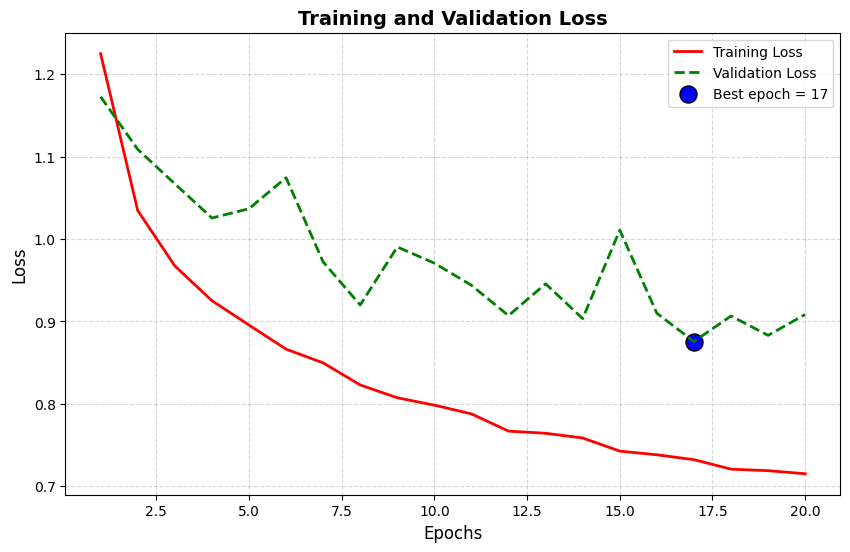

In [20]:
best_epoch_loss = np.argmin(val_loss)
best_val_loss = val_loss[best_epoch_loss]

plt.figure(figsize=(10, 6))
plt.plot(epochs, tr_loss, color='red', label='Training Loss', linewidth=2)
plt.plot(epochs, val_loss, color='green', label='Validation Loss', linestyle='--', linewidth=2)
plt.scatter(best_epoch_loss + 1, best_val_loss, s=150, c='blue',
            label=f'Best epoch = {best_epoch_loss + 1}', edgecolors='black')
plt.title('Training and Validation Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=10)
plt.grid(visible=True, linestyle='--', alpha=0.5)
plt.show()

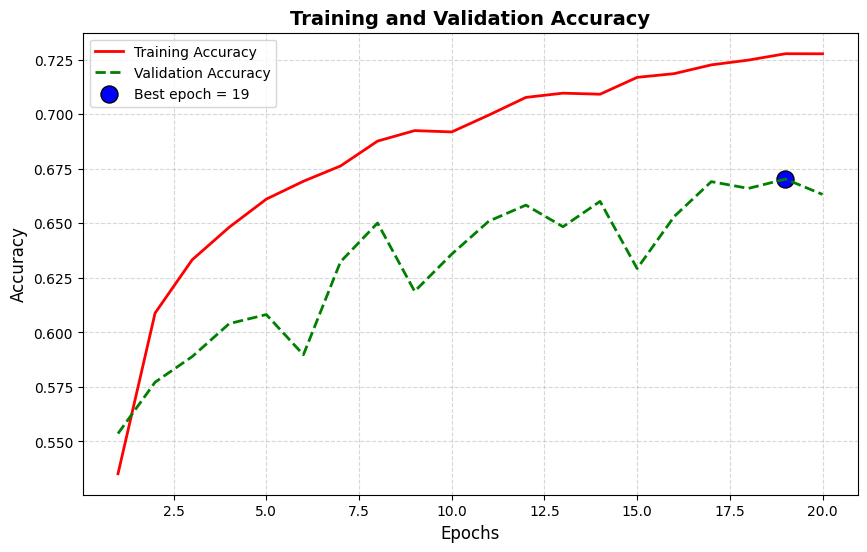

In [21]:
best_epoch_acc = np.argmax(val_acc)
best_val_acc = val_acc[best_epoch_acc]

plt.figure(figsize=(10, 6))
plt.plot(epochs, tr_acc, color='red', label='Training Accuracy', linewidth=2)
plt.plot(epochs, val_acc, color='green', label='Validation Accuracy', linestyle='--', linewidth=2)
plt.scatter(best_epoch_acc + 1, best_val_acc, s=150, c='blue',
            label=f'Best epoch = {best_epoch_acc + 1}', edgecolors='black')
plt.title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=10)
plt.grid(visible=True, linestyle='--', alpha=0.5)
plt.show()


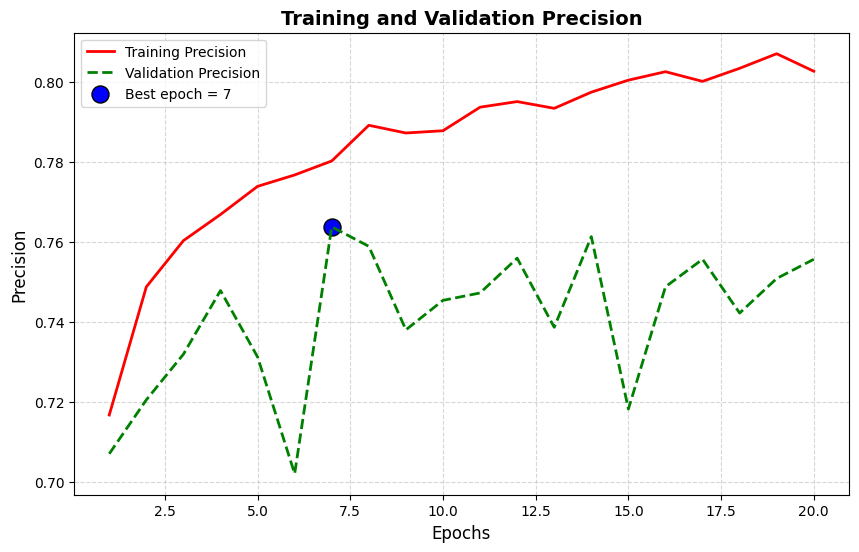

In [22]:
best_epoch_prec = np.argmax(val_precision)
best_val_prec = val_precision[best_epoch_prec]

plt.figure(figsize=(10, 6))
plt.plot(epochs, tr_precision, color='red', label='Training Precision', linewidth=2)
plt.plot(epochs, val_precision, color='green', label='Validation Precision', linestyle='--', linewidth=2)
plt.scatter(best_epoch_prec + 1, best_val_prec, s=150, c='blue',
            label=f'Best epoch = {best_epoch_prec + 1}', edgecolors='black')
plt.title('Training and Validation Precision', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.legend(fontsize=10)
plt.grid(visible=True, linestyle='--', alpha=0.5)
plt.show()


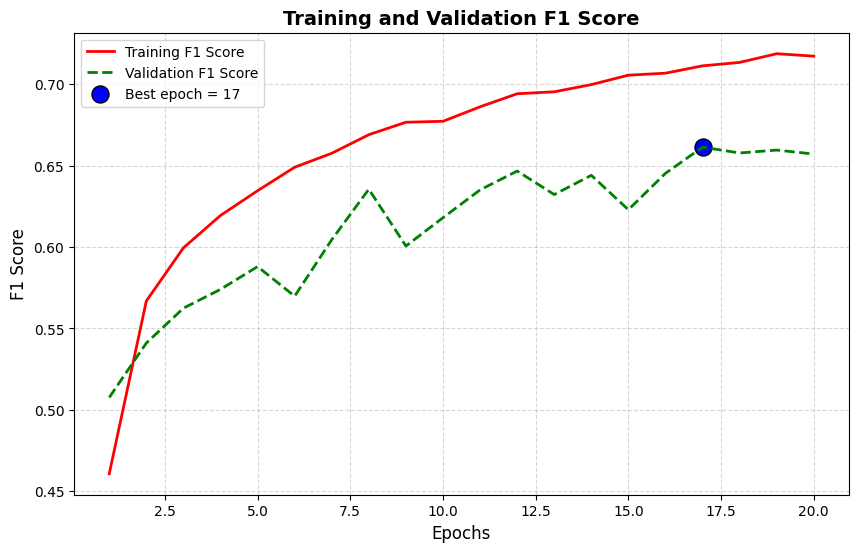

In [23]:
best_epoch_f1 = np.argmax(val_f1)
best_val_f1 = val_f1[best_epoch_f1]

plt.figure(figsize=(10, 6))
plt.plot(epochs, tr_f1, color='red', label='Training F1 Score', linewidth=2)
plt.plot(epochs, val_f1, color='green', label='Validation F1 Score', linestyle='--', linewidth=2)
plt.scatter(best_epoch_f1 + 1, best_val_f1, s=150, c='blue',
            label=f'Best epoch = {best_epoch_f1 + 1}', edgecolors='black')
plt.title('Training and Validation F1 Score', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)
plt.legend(fontsize=10)
plt.grid(visible=True, linestyle='--', alpha=0.5)
plt.show()

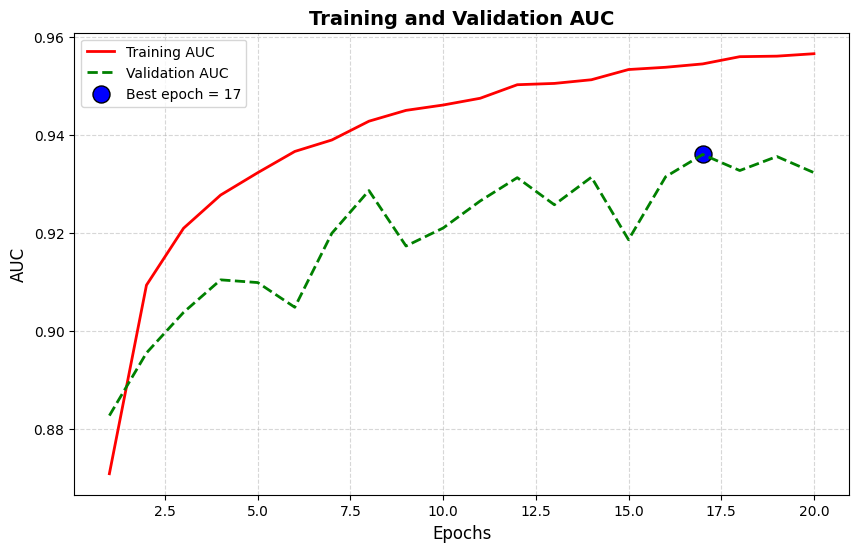

In [24]:
best_epoch_auc = np.argmax(val_auc)
best_val_auc = val_auc[best_epoch_auc]

plt.figure(figsize=(10, 6))
plt.plot(epochs, tr_auc, color='red', label='Training AUC', linewidth=2)
plt.plot(epochs, val_auc, color='green', label='Validation AUC', linestyle='--', linewidth=2)
plt.scatter(best_epoch_auc + 1, best_val_auc, s=150, c='blue',
            label=f'Best epoch = {best_epoch_auc + 1}', edgecolors='black')
plt.title('Training and Validation AUC', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('AUC', fontsize=12)
plt.legend(fontsize=10)
plt.grid(visible=True, linestyle='--', alpha=0.5)
plt.show()

In [25]:
def evaluate_model(model, test_data, labels, model_name, test_dataframe, batch_size=BATCH_SIZE):
    """
    Evaluate a trained Keras model using a test data generator.

    Args:
        model (Model): Trained Keras model.
        test_data (Iterator): A Keras data generator for testing.
        labels (List[str]): Class label names.
        model_name (str): Name of the model (for display).
        test_dataframe (pd.DataFrame): DataFrame with test samples (for step calculation).
        batch_size (int): Batch size used in the test_data generator.

    Returns:
        Tuple[dict, dict]: 
            - Dictionary containing accuracy, precision, recall, F1 score, and AUC.
            - Dictionary of AUC curve data {class_label: (fpr, tpr)} for ROC plotting.
    """
    import math
    import numpy as np
    from sklearn.metrics import (
        accuracy_score, precision_score, recall_score, f1_score,
        roc_auc_score, roc_curve, classification_report, confusion_matrix
    )
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Calculate steps needed for full evaluation
    steps = math.ceil(len(test_dataframe) / batch_size)

    y_true = []
    y_pred = []
    y_probs = []

    # Loop through batches and collect predictions and true labels
    for _ in tqdm(range(steps), desc=f"Evaluating {model_name}"):
        images, labels_batch = next(test_data)

        preds = model.predict(images, verbose=0)            # Predicted probabilities
        y_probs.extend(preds)                               # Save for AUC

        y_pred.extend(np.argmax(preds, axis=-1))            # Predicted class indices
        y_true.extend(np.argmax(labels_batch, axis=-1))     # True class indices

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_probs = np.array(y_probs)

    # Calculate performance metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average="weighted")
    recall = recall_score(y_true, y_pred, average="weighted")
    f1 = f1_score(y_true, y_pred, average="weighted")

    try:
        auc = roc_auc_score(y_true, y_probs, multi_class='ovr', average='weighted')
    except ValueError:
        auc = float('nan')

    # Generate classification report
    report = classification_report(y_true, y_pred, target_names=labels)

    # Print summary metrics
    print(f"--- {model_name} ---")
    print(f"Accuracy : {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"F1 Score : {f1:.4f}")
    print(f"AUC      : {auc:.4f}\n")
    print("Classification Report:\n")
    print(report)

    # Plot confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm, annot=True, fmt='d', cmap='Blues',
        xticklabels=labels, yticklabels=labels,
        annot_kws={'size': 14}, cbar=True, linewidths=0.5, linecolor='gray',
        cbar_kws={'shrink': 0.8}
    )
    plt.title(f'Confusion Matrix: {model_name}', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Predicted Label', fontsize=14, fontweight='bold')
    plt.ylabel('True Label', fontsize=14, fontweight='bold')
    plt.xticks(fontsize=12, rotation=45 if len(labels) > 10 else 0)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()

    # Compute ROC curve data per class
    auc_curve_data = {}
    try:
        for i, label in enumerate(labels):
            fpr, tpr, _ = roc_curve((y_true == i).astype(int), y_probs[:, i])
            auc_curve_data[label] = (fpr, tpr)
    except Exception:
        auc_curve_data = {}

    return {
        "model_name": model_name,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "auc": auc
    }, auc_curve_data


Evaluating NASNetMobile: 100%|██████████| 294/294 [00:44<00:00,  6.62it/s]


--- NASNetMobile ---
Accuracy : 0.6709
Precision: 0.6662
Recall   : 0.6709
F1 Score : 0.6619
AUC      : 0.9295

Classification Report:

              precision    recall  f1-score   support

       akiec       0.68      0.59      0.63       670
         bcc       0.67      0.59      0.63       670
         bkl       0.54      0.50      0.52       671
          df       0.69      0.85      0.76       671
         mel       0.59      0.41      0.48       671
          nv       0.62      0.83      0.71       670
        vasc       0.87      0.93      0.90       671

    accuracy                           0.67      4694
   macro avg       0.67      0.67      0.66      4694
weighted avg       0.67      0.67      0.66      4694



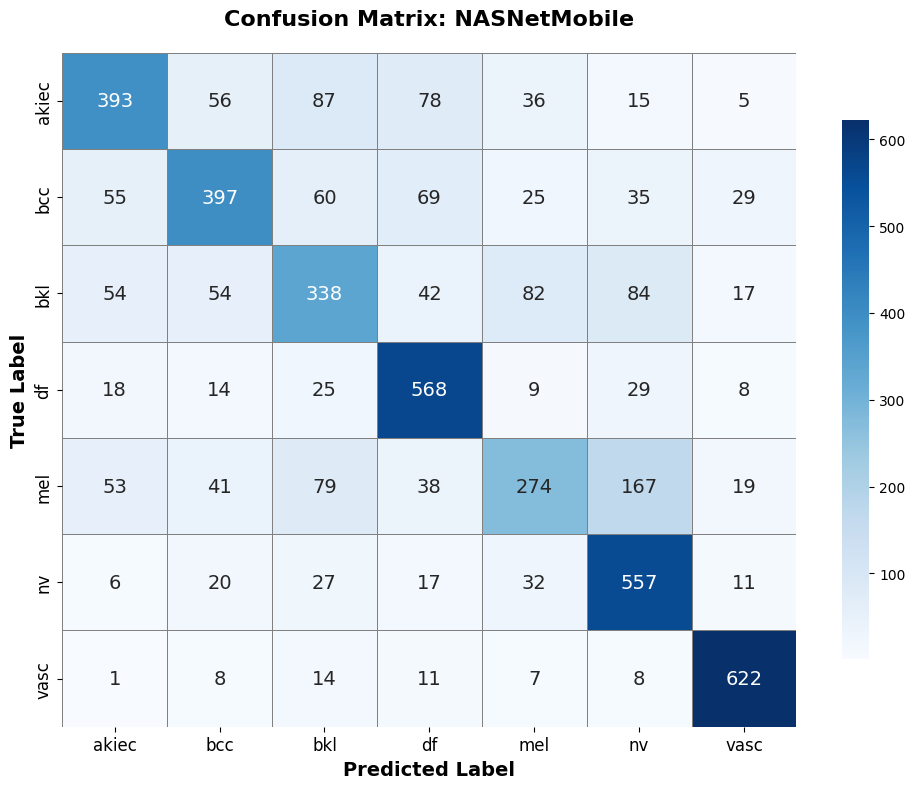

In [26]:
results, auc_curve_data = evaluate_model(model, test_data, labels, model_name, test_dataframe)

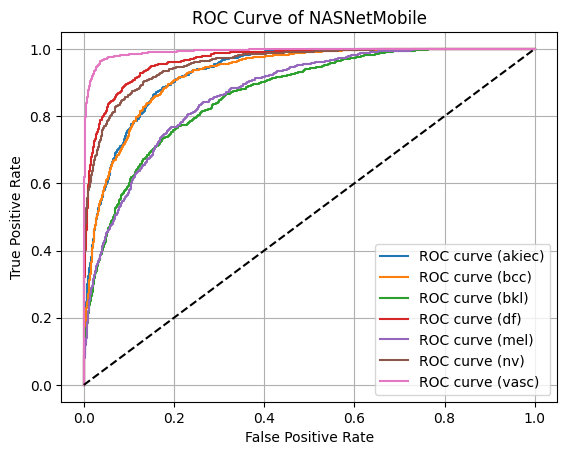

In [27]:
# Plotting the ROC curve
for label, (fpr, tpr) in auc_curve_data.items():
    plt.plot(fpr, tpr, label=f'ROC curve ({label})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve of {model_name}')
plt.legend()
plt.grid(True)
plt.show()